### Clustering with algoritm Gaussian kernel fuzzy c-means 

This is a implementation with dataset Multiple features in the repository (https://archive.ics.uci.edu/dataset/72/multiple+features)
we apply with tree datasets (mfeat-fac, mfeat-fou, mfeat-kar) for each do it:
  - 50 times, with c=10 for partation fuzzy
  - compute Modified partition coefficient
  - paraments $T = 100, \epsilon=10^{-6}, m = {1.01, 1.1, 1.6}$

  - show the bests with based in fuction cost:
    - prototatipes ${g_{1},..., g_n}$
    - widths ${s_1,..., s_n}$
    - confusion matrix 


base article: Gaussian Kernel Fuzzy C-Means with Width Parameter Computation and Regularization.
PATTERN RECOGNITION, v. 143, p. 109749, 2023, 
doi: https://doi.org/10.1016/j.patcog.2023.109749 

***
Gaussian kernel function
***
$$
  K^{(s_i)}(x_l, x_k) = exp{
    \displaystyle 
    \Bigg \{
      -\frac{1}{2}
      \sum \limits _{j=1}^p 
        \frac{1}{{s^2}_{ij}}
        (x_{lj} - x_{kj})^2
    \Bigg \} 
    }
$$

***
objective  function
***

$$
  J_{KFCM-K-W.2} = 
    \displaystyle 
      \sum \limits _{i=1}^c 
        \sum \limits _{k=1}^n 
          (u_{ki})^m
          (2 - 2{K^{(s_i)}(x_k, g_i)})
$$

$
  s.t. u_{ki} \ge 0
$ and 
$
  \sum \limits _{i=1}^c 
    u_{ki} = 1
$

***
width
***

$$
\frac{1}{s_{ij}} = 
  \frac{
    \Bigg \{
      \prod \limits _{h=1}^p 
        \sum \limits _{k=1}^n 
          {(u_{ki})^m}
          {K^{(s_i)}(x_k, g_i)}
          {(x_{kh} - g_{ih})^2}
    \Bigg \}^
    {
      \frac{1}{p}
    }
  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {(x_{kj} - g_{ij})^2}
  } 

$$

***
prototipes
***

$$
g_i = 
  \frac{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
      {x_k}

  }{
    \sum \limits _{k=1}^n 
      {(u_{ki})^m}
      {K^{(s_i)}(x_k, g_i)}
  } 
$$
$$
  \forall (1 \le i \le c)
$$

***
fuzzy matrix
***

$$
  u_{ki} = 
    \Bigg [ 
      \sum \limits _{h=1}^c 
        \Bigg ( 
          \frac{
            2 - 2{K^{(s_i)}(x_k, g_i)}
          }{
            2 - 2{K^{(s_i)}(x_k, g_h)}
          }
        \Bigg )^
        {
          \frac{1}{m-1}
        } 
    \Bigg ] ^{-1}
$$

### Librarys

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Data transform

In [2]:
class Cleaner(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  
  def read_dataset(self, filename):
    X = pd.read_csv(filename, header=None, delim_whitespace=True)
    y = pd.DataFrame({X.shape[1]: np.arange(0, X.shape[0])//200})
    return X, y

  def fit(self, X, y):
    return self
  
  def transform(self, X: pd.DataFrame, y=pd.DataFrame):
    y_lenth = len(y)
    if y_lenth:
      # key = "class"
      # y = pd.DataFrame({key: y})
      values = pd.concat([X, y], axis=1)
    else:
      values = X.copy()

    values = values.dropna()
    values = values.drop_duplicates()
    if y_lenth:
      return values[X.columns.values], values[values.columns.values[-1]]
    return values
  
  def fit_transform(self, X, y=pd.DataFrame):
      return self.fit(X, y).transform(X, y)
  
class Transformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    super()
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if type(X) == np.ndarray:
      return X
    return X.values
  def fit_transform(self, X, y=None):
    return self.fit(X, y).transform(X, y)

### Metrics

In [3]:
class Gaussian:
  def distance(self, g, x, sigma):
    if x.shape[0] == 0 or sigma.shape[0] == 0:
      raise Exception
    distance = (x - g)**2
    distance_sigma = distance / sigma
    summatory_distance = (-1/2)*np.sum(distance_sigma, 1)
    return np.exp(summatory_distance)

class Metrics:
  def mpc(u: np.array):
    # modified partition coefficient
    n, k = u.shape
    f = np.trace(u.dot(u.T)) / n

    mpc = 1 - (k/(k - 1))*(1 - f)
    return mpc
  def ars(y_true, y_pred):
    # adjusted rand score
    return adjusted_rand_score(y_true, y_pred)

### Model

In [4]:
# tá funcionando bonitinho
class Shower():
  def show_grafico(self, x):
    _, axes = plt.subplots()
    markers = ['^','x','+']
    p = self.predict(self.G, x)
    
    for (c, (x_1, x_2)) in zip(p, x):
      r, g, b, a = .9*((c+1)/self.num_class), .9*((c*1.1)/self.num_class), .9*((c*1.2)/self.num_class), 0.1
      
      axes.plot(x_1, x_2, "ro", marker=markers[c])
        
    raio = self.distance_classes() / 2
    
    for i, (x_1, x_2) in enumerate(self.G):
        
        plt.plot(x_1, x_2, "go", scalex=0.01,scaley=0.01)
        r, g, b, a = .9*((i+1)/self.num_class), .9*((i*1.1)/self.num_class), .9*((i*1.2)/self.num_class), 0.9
        c = plt.Circle((x_1, x_2), raio, color=(r, g, b, a), fill=False)

        axes.set_aspect(aspect = 1, adjustable = "datalim", anchor="SW")
        axes.add_artist(c)
    plt.show()

  def show_labels(self, x, filename):
    # Data
    k, n = x.shape
    plt.figure(figsize=(20, 6))
      
    # Labels  
    xlabs = np.arange(k)
    ylabs = np.arange(n)
            
    # Heat map
    _, ax = plt.subplots(constrained_layout=True)
    
    # ax.figure()
    ax.set_axis_off() #= [0.1, 0.1, 0.8, 0.8] #.add_axes()
    ax.imshow(x)
    if n < 10:
      # Add the labels
      ax.set_xticks(ylabs)
      ax.set_yticks(xlabs)

      # Add the values to each cell
      for i in range(len(xlabs)):
          for j in range(len(ylabs)):
              _ = ax.text(j, i , round(x[i, j], 1),
                            ha = "center", va = "center", color = (0,0,0)) # "w"
    if filename:
      plt.savefig(filename, dpi=150)
    plt.show()
  
  def show_G_S(self, folder):
    # show the values of Gs and S(widths)
    if not os.path.isdir(folder):
      os.makedirs(folder) 
    print("Gs")
    self.show_labels(self.G, f"{folder}/G")
    print("S2s")
    self.show_labels(self.sigma, f"{folder}/sigma")

class Model():
  def __init__(self, loss = Gaussian(), var_type=np.double) -> None:
    # model base
    self.loss = loss
    self.var_type = var_type
    
  def predict(self, X, is_preprocessing=False):
    # here we make predict in x
    n = X.shape[0] 
    k = self.G.shape[0]

    if is_preprocessing:
      X = self.preprocesssing(X)

    predict_value = np.zeros((n, k), dtype=self.var_type)

    for i in range(k):
      predict_value[:,i] = self.loss.distance(self.G[i], X, self.sigma[i])
    return predict_value.argmax(1)

  def set_g(self, g):
    self.G = g.copy()

  def set_sigma(self, sigma):
    self.sigma = sigma.copy()

  def preprocesssing(self, X):
    pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),])    
    
    return pipeline.transform(X)
  
  def save_model(self, filename):
    # Save the model in json file
    json_object = json.dumps({
      "G": self.G.tolist(),
      "sigma": self.sigma.tolist()
    }, indent=2) #  
    # Writing to sample.json
    folder = "/".join(filename.split("/")[:-1])
    if not os.path.isdir(folder):
      os.makedirs(folder) 

    with open(filename, "w") as outfile:
        outfile.write(json_object)
  
  def load_model(self, filename):
    # Reading from json file
    with open(filename, 'r') as openfile:
      json_object = json.load(openfile)
      self.G = np.array(json_object["G"])
      self.sigma = np.array(json_object["sigma"])

class FuzzyCMeansGaussianS2(Shower, Model):
  def __init__(self, num_class, epochs, threshold, loss=Gaussian(),  m = 1.1, seeder=None, verbose = False) -> None:
    # load the hiperparams
    super().__init__(loss=loss, var_type = np.double)
    self.num_class = num_class
    self.m = m 
    self.verbose = verbose
    self._only = True
    if seeder:
      self.seeder = seeder
      np.random.seed(seeder)
      
    self.threshold = threshold
    self.epochs = epochs 
 
  def init_g(self, x):
    # here we get random prototipes to train
    args = np.random.choice(x.shape[0], self.num_class, replace=False)
    self.G = x[args].copy()

  def init_u(self, x):
    # we calcule initial matrix of membership
    g = self.G.copy()
    sigma = self.sigma.copy()
    self.n = x.shape[0]
    self.k = g.shape[0]
    
    self.U = np.zeros((self.n, self.k), self.var_type)

    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T

    expoente = 1/(self.m-1)

    for i in range(self.n):
      # summation_c = np.array([(distances[i, h] / distances[i])**expoente for h in range(self.k)]) 
      # np.divide
      # summation_c = np.array([(distances[i] / distances[i, h])**expoente for h in range(self.k)]) #.T 
      ds = distances[i]==0
      if (ds).any():
        summation_c_i_1 = np.zeros((self.k))
        summation_c_i_1[ds] = 1
        self.U[i] = summation_c_i_1.copy()

      else:
        summation_c = np.array([((distances[i]/distances[i, h])**expoente) for h in range(self.k)])#.T 
        
        summation_c_i = np.sum(summation_c, 0)
        summation_c_i_1 = np.power(summation_c_i, -1)
        
        membership_is_nan = np.isnan(summation_c_i_1)
        
        summation_u = np.sum(summation_c_i_1, where=membership_is_nan==False)

        summation_u_1 = 1 - summation_u
        abs_summation_u_1 = np.abs(summation_u_1)
        
        if abs_summation_u_1 > .01:
          arg = summation_c_i_1.argmax()
          summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1
          
          self.U[i] = summation_c_i_1.copy()
        else:
          self.U[i] = summation_c_i_1.copy() 
   
  def init_sigma(self, x):
    # we calcule initial matrix of widths each 1
    self.p = x.shape[1]
    self.k = self.G.shape[0]
    self.sigma = np.ones((self.k, self.p), dtype=self.var_type)

  # passo 1
  def otm_prototivo(self, g, u, x, sigma):
    new_g = g.copy()
    u_i = u**self.m

    for i in range(self.k):
      n_g = self.loss.distance(g[i], x, sigma[i])
      
      u_m_g = (u_i[:,i]*n_g)#*
      u_m_gx = ((x.T)*u_m_g).T

      s_umg = np.sum(u_m_g)
      s_umgx = np.sum(u_m_gx, 0)
      
      new_g[i] = s_umgx / s_umg 
    return new_g
  
  # passo 2
  def otm_u(self, g, x, sigma):
    new_u = np.zeros((self.n, self.k), dtype=self.var_type)  
    
    distances = np.array([2 - 2*self.loss.distance(g[i], x, sigma[i]) for i in range(self.k)]).T
    
    expoente = 1/(self.m-1)
    for i in range(self.n):
      
      ds = distances[i]==0
      if (ds).any():
        summation_c_i_1 = np.zeros((self.k))
        summation_c_i_1[ds] = 1
        new_u[i] = summation_c_i_1.copy()
        
      else:
        summation_c = np.array([((distances[i]/distances[i, h])**expoente) for h in range(self.k)])#.T 
        
        summation_c_i = np.sum(summation_c, 0)

        summation_c_i_1 = np.power(summation_c_i, -1)
        
        membership_is_nan = np.isnan(summation_c_i_1)
        
        summation_u = np.sum(summation_c_i_1, where=membership_is_nan==False)

        summation_u_1 = 1 - summation_u
        abs_summation_u_1 = np.abs(summation_u_1)
        # if 
      
        if summation_u == 0 or membership_is_nan.any():
          count = np.sum(membership_is_nan) # total nan
          new_u[i] = np.nan_to_num(summation_c_i_1, nan = summation_u_1/count)     
        elif abs_summation_u_1 > .01:
          arg = summation_c_i_1.argmax()
          summation_c_i_1[arg] = summation_c_i_1[arg] + summation_u_1
          
          new_u[i] = summation_c_i_1.copy()
        else:
          new_u[i] = summation_c_i_1.copy()
    return new_u

  def otm_sigma(self, x, g, u):
    s = self.sigma.copy()
    
    ui = (u**(self.m))
    
    for i in range(self.k):
      g_i = g[i]
      ui_per = ui[:,i]
      

      g_d = self.loss.distance(g_i, x, s[i]) 
      e_d = (x - g_i)**2 
      
      s_cn = e_d.T*(ui_per*g_d)
      
      if s_cn.shape[1] != 1:
        ss_cn = np.sum(s_cn, 1).copy()
      else:
        ss_cn = np.squeeze(s_cn, 1).copy()
        

      s_p = np.prod(ss_cn)
      s_p = s_p**(1/self.p)
      
      s_ij = s_p / ss_cn 

      r_r = s_ij[np.isnan(s_ij) == False]
      p_r = np.prod(r_r)
      
      s_r = np.abs(1 - p_r)
      
              
      # verificacao do produtorio para a classe que deve ser 1
      if p_r == 0: 
        # quando os Si forem muito pequeno o produtorio dá zero por causa computacional
        # sendo assim eu redistubuo a partir do inverso da media
        # ss_cn => todos denominadores de Si
        # [1/2, 1/2, 1/2] = [0.1/0.2 0.1/0.2 0.1/0.2] 

        # [S_i1, S_i2, S_i3] = [0.000398*0.0000038*0.000067/0.000398 
        #                       0.000398*0.0000038*0.000067/0.0000038 
        #                       0.000398*0.0000038*0.000067/0.000067]
        #  [S_i1, S_i2, S_i3] = [2.5460e-10, 2.6666e-08, 1.5124e-09]

        # -1 aqui faco a media dos denominadores dos si 
        # que no caso o resultado dos somatorios 
        teste = False

        if teste:
          m_s = np.sum(ss_cn)/(self.p) 
        # m_s = sum([0.2 0.2 0.2])/2

        # p
        # m_s = sum([0.000398 0.0000038 0.000067])/3
        # m_s = 0.00015626666666666668
        # p - 1
        # m_s = sum([0.000398 0.0000038 0.000067])/2
        # m_s = 0.0002344



        # ss_cn = ss_cn*(1/m_s)
        if teste:
          im_s = 1/(m_s)
          new_ss_cn = ss_cn*im_s
        else:
          new_ss_cn = (1 - ss_cn) #**(1/(self.p))
        # new_ss_cn = [0.0033 0.0033 0.0033]/0.2


        # p
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.00015626666666666668
        # new_ss_cn = [2.54692833 0.02431741 0.42875427]

        # p - 1
        # new_ss_cn = [0.000398 0.0000038 0.000067]/0.0002344
        # new_ss_cn = [1.69795222 0.0162116 0.28583618]

        new_s_p = np.prod(new_ss_cn)
        # p
        # prod(new_ss_cn) = 0.0265547628046677

        # p -1
        # prod(new_ss_cn) = 0.00786807786804969


        new_s_p = new_s_p**(1/self.p)
        # p
        # new_s_p = 0.29834182508986407

        # p -1
        # new_s_p = 0.08870218637694163

        
        new_r = new_s_p / new_ss_cn 

        # p
        # new_r = 0.0265547628046677/[2.54692833 0.02431741 0.42875427]
        # new_r = [0.1171379 , 12.2686533 ,  0.69583407]
        # prod(new_ss_cn) = 0.75

        # p -1
        # new_r = 0.4898979485566356/[1.69795222 0.0162116 0.28583618]
        # new_r = [0.05224068, 5.47152434, 0.31032526 ]

        prod = np.prod(new_r)
        # p
        # prod = 1
        # p -1
        # prod = 0.0887021863769416

        if np.isnan(prod)==False:
          s[i] = new_r.copy()
        
      elif s_r > .1:
        # para quando o produtorio de Ss dá diferente de 1 
        if r_r.shape[0] == s_ij.shape[0]:
          s[i] = s_ij/(p_r**(1/s_ij.shape[0]))
        else:
          s_prod = (1/(p_r**(1/s_ij.shape[0])))
          s[i] = np.nan_to_num(s_ij, copy=True, nan=s_prod)
      else:
        s[i] = s_ij.copy()
          
    return s

  def funcao_objetivo(self, x, g, u, sigma):
    # k = g.shape[0]
    u_i = u**self.m
    f = np.zeros(self.k, dtype=self.var_type)
    
    s_d = np.zeros(x.shape[0], dtype=self.var_type)
    w = np.zeros(x.shape[0], dtype=self.var_type)
    for i in range(self.k):
      s_d = 2 - 2*self.loss.distance(g[i], x, sigma[i])
      
      w = s_d.T*(u_i[:, i])
      f[i] = np.sum(w)
      
    return np.sum(f)

  def atualiza_GUS2(self, g, u, sigma):
    self.G = g
    self.U = u
    self.sigma = sigma

  def fit(self, x, y, verbose = False):
    self.redu = True
    
    self.init_g(x)
    self.init_sigma(x)
    self.init_u(x)

    j = self.funcao_objetivo(x, self.G, self.U, self.sigma) 
    if self._only:
      print("epoca:", 0, "funcão objetivo:", j) #, new_f

    
    for epoch in range(self.epochs):
      # "passo 1"
      new_sigma = self.otm_sigma(x, self.G, self.U)

      # "passo 2"
      new_g = self.otm_prototivo(self.G, self.U, x, new_sigma)

      # "passo 3"
      new_u = self.otm_u(new_g, x, new_sigma)

      new_j = self.funcao_objetivo(x, new_g, new_u, new_sigma)
      if self._only:
        print(f"epoca: {epoch + 1} funcão objetivo: {new_j}")# f,
        print(f"Modified partition coefficient  {Metrics.mpc(self.U)},  {Metrics.ars(y, self.U.argmax(1))}")# f,
      
      # silhouette_score
      if verbose:
        self.show_grafico(x)
      
      dif = np.abs(new_j - j)
      # new_j > j
      if (np.isnan(new_j)==True or dif < self.threshold):
        return
      else:
        j = new_j
        self.atualiza_GUS2(new_g, new_u, new_sigma)

class Trainer(Shower, Model):
  def __init__(self, num_class, epochs, threshold, model_creator, loss = Gaussian(), m = 1.1, verbose = False, repeat = 1) -> None:
    # load the hiperparams
    super().__init__(loss=loss)
    self.num_class = num_class
    self.var_type = np.double
    # self.var_type = np.float
    self.m = m 
    self.verbose = verbose      
    self.threshold = threshold
    self.epochs = epochs 
    self.repeat = repeat
    self.model_creator = model_creator
    
  def fit(self, X, y):
    j = np.inf
    
    for i in range(self.repeat):
      model = self.model_creator(num_class=self.num_class, epochs=self.epochs, threshold=self.threshold, loss=self.loss, m=self.m, verbose=self.verbose)
      model._only = False
      model.fit(X, y)
      new_j = model.funcao_objetivo(X, model.G, model.U, model.sigma)
      print(f"repeation: {i + 1} funcão objetivo: {new_j}")
      print(f"Modified partition coefficient: {Metrics.mpc(model.U)},  adjusted_rand_score: {Metrics.ars(y, model.U.argmax(1))}")

      if new_j < j:
        self.G = model.G
        self.U = model.U
        self.sigma = model.sigma
        j = new_j


## fit the model with datasets

### m = 1.1

#### set m expoent fuzzy

In [5]:
m = 1.1

#### datasets -> mfeat-fac

In [6]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fac")
X, y = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-fac/model.json")


repeation: 1 funcão objetivo: 12.71028228273393
Modified partition coefficient: 0.9117606852948938,  adjusted_rand_score: 0.4661131247574353
repeation: 2 funcão objetivo: 12.670229905007218
Modified partition coefficient: 0.9213976360558613,  adjusted_rand_score: 0.4595014909087241
repeation: 3 funcão objetivo: 12.966631700747163
Modified partition coefficient: 0.922427214477029,  adjusted_rand_score: 0.4327516942554979
repeation: 4 funcão objetivo: 12.70658000569979
Modified partition coefficient: 0.914551332218581,  adjusted_rand_score: 0.44167813597155775
repeation: 5 funcão objetivo: 12.873672637090277
Modified partition coefficient: 0.9042124598994308,  adjusted_rand_score: 0.44767321698057005
repeation: 6 funcão objetivo: 12.872326348115582
Modified partition coefficient: 0.9066583822031826,  adjusted_rand_score: 0.4544076680247264
repeation: 7 funcão objetivo: 12.85686586073407
Modified partition coefficient: 0.9108696846297841,  adjusted_rand_score: 0.4524767984218396
repeation

Gs


<Figure size 1440x432 with 0 Axes>

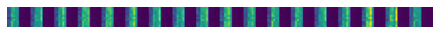

S2s


<Figure size 1440x432 with 0 Axes>

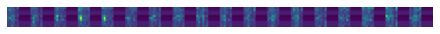

In [7]:
model.show_G_S("./figs/mfeat-fac")

Modified partition coefficient:  {0: 0.9728891340224581, 1: 0.857039777387311, 2: 0.9013148675618663, 3: 0.9159804225448858, 4: 0.9224295393690065, 5: 0.89525381378097, 6: 0.9287130662738845, 7: 0.9079974841627532, 8: 0.9279084324215762, 9: 0.9313042952115405}
Índice de Rand corrigido: 0.5083299450786316


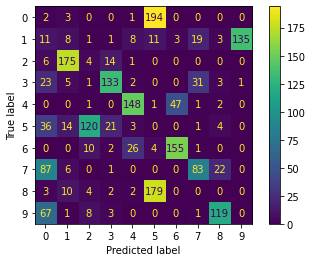

In [8]:
y_predict = pipeline.predict(X) 

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-fou

In [9]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fou")
X, y = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-fou/model.json")

repeation: 1 funcão objetivo: 334.4261547263179
Modified partition coefficient: 0.8658478123848963,  adjusted_rand_score: 0.4455003958092822
repeation: 2 funcão objetivo: 333.056213488078
Modified partition coefficient: 0.858270648932214,  adjusted_rand_score: 0.45674865671036874
repeation: 3 funcão objetivo: 380.3331167259837
Modified partition coefficient: 0.8518982164622109,  adjusted_rand_score: 0.2791064991773775
repeation: 4 funcão objetivo: 333.0572980980178
Modified partition coefficient: 0.8580671839466356,  adjusted_rand_score: 0.45711296387908623
repeation: 5 funcão objetivo: 384.88073587883144
Modified partition coefficient: 0.8359904421322026,  adjusted_rand_score: 0.38276755681567654
repeation: 6 funcão objetivo: 366.15033376113104
Modified partition coefficient: 0.7877371662389019,  adjusted_rand_score: 0.3618756965484745
repeation: 7 funcão objetivo: 340.81454830796474
Modified partition coefficient: 0.8288565087737765,  adjusted_rand_score: 0.4078782533546311
repeation

Gs


<Figure size 1440x432 with 0 Axes>

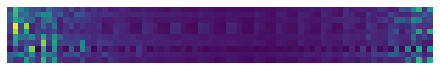

S2s


<Figure size 1440x432 with 0 Axes>

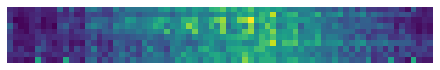

In [10]:
model.show_G_S("./figs/mfeat-fou")

Modified partition coefficient:  {0: 0.9912090409546107, 1: 0.6845021475771224, 2: 0.9236607903230348, 3: 0.8357442996793674, 4: 0.8277839278185013, 5: 0.7785685184796496, 6: 0.9038073644364366, 7: 0.8909910201549246, 8: 0.8468029324133681, 9: 0.8848303555412317}
Índice de Rand corrigido: 0.4593691573080957


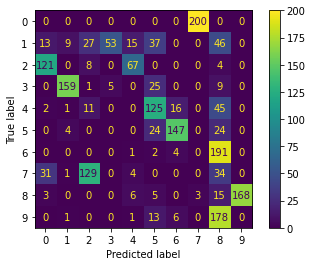

In [11]:
y_predict = pipeline.predict(X)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-kar

In [12]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-kar")
X, y = cleaner.transform(X, y)
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-kar/model.json")


repeation: 1 funcão objetivo: 1817.406844483708
Modified partition coefficient: 0.7062106347807877,  adjusted_rand_score: 0.48316300208618757
repeation: 2 funcão objetivo: 1799.6234763711338
Modified partition coefficient: 0.7211636731583752,  adjusted_rand_score: 0.49616315876723455
repeation: 3 funcão objetivo: 1820.5468047272793
Modified partition coefficient: 0.713731611429993,  adjusted_rand_score: 0.4552521631023444
repeation: 4 funcão objetivo: 1806.251180297651
Modified partition coefficient: 0.7103963334053751,  adjusted_rand_score: 0.5762327398932902
repeation: 5 funcão objetivo: 1824.2907720028863
Modified partition coefficient: 0.7186065023284489,  adjusted_rand_score: 0.5704537377556418
repeation: 6 funcão objetivo: 1806.2514962582875
Modified partition coefficient: 0.7103964883134739,  adjusted_rand_score: 0.5762327398932902
repeation: 7 funcão objetivo: 1806.2501603034827
Modified partition coefficient: 0.7103958520237935,  adjusted_rand_score: 0.5762327398932902
repeati

Gs


<Figure size 1440x432 with 0 Axes>

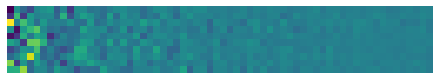

S2s


<Figure size 1440x432 with 0 Axes>

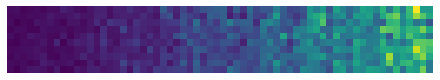

In [13]:
model.show_G_S("./figs/mfeat-kar")

Modified partition coefficient:  {0: 0.8478930134522046, 1: 0.7115097208682345, 2: 0.6610287096215148, 3: 0.7347900695031241, 4: 0.8100420022680646, 5: 0.7230896392997364, 6: 0.8010198141629385, 7: 0.7492717927041419, 8: 0.3587970718104032, 9: 0.8155966406433888}
Índice de Rand corrigido: 0.49616315876723455


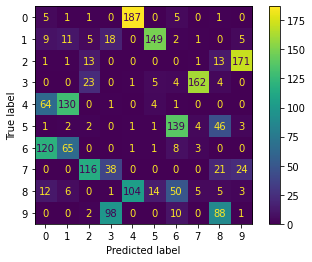

In [14]:
y_predict = pipeline.predict(X)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> iris

In [15]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame({len(X.columns.values):iris.target})
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 3, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)
 
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model),
                    ])

pipeline.fit(X, y)
model.save_model(f"./model/{m}/iris/model.json")
y_predict = pipeline.predict(X)


repeation: 1 funcão objetivo: 0.4057809326062767
Modified partition coefficient: 0.9869919974104987,  adjusted_rand_score: 0.9035691663683182
repeation: 2 funcão objetivo: 0.405779375486201
Modified partition coefficient: 0.9869916601342325,  adjusted_rand_score: 0.9035691663683182
repeation: 3 funcão objetivo: 0.5360545073848532
Modified partition coefficient: 0.9901787208647157,  adjusted_rand_score: 0.443540461316264
repeation: 4 funcão objetivo: 0.5360539849709847
Modified partition coefficient: 0.9901808878717024,  adjusted_rand_score: 0.443540461316264
repeation: 5 funcão objetivo: 0.5360549691989909
Modified partition coefficient: 0.9901765449972113,  adjusted_rand_score: 0.443540461316264
repeation: 6 funcão objetivo: 0.40578026574670734
Modified partition coefficient: 0.9869918388901359,  adjusted_rand_score: 0.9035691663683182
repeation: 7 funcão objetivo: 0.40577974687152385
Modified partition coefficient: 0.9869917432990598,  adjusted_rand_score: 0.9035691663683182
repeatio

In [16]:
new_model = Model()
new_model.load_model("model/iris/model.json")
y_predict = new_model.predict(X, True)#.shape, X.shape


Gs


<Figure size 1440x432 with 0 Axes>

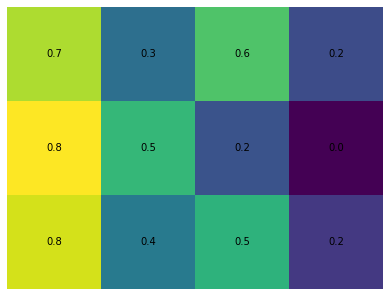

S2s


<Figure size 1440x432 with 0 Axes>

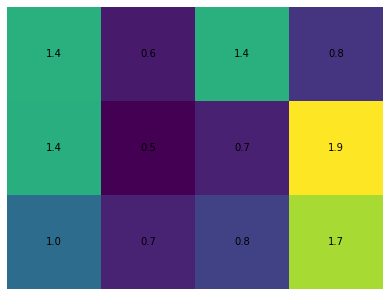

In [17]:
model.show_G_S("figs/iris")

Modified partition coefficient:  {0: 0.9999999952007834, 1: 0.9657792230542875, 2: 0.9953630458639118}
Índice de Rand corrigido: 0.9035691663683182


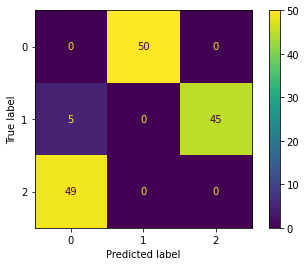

In [18]:
y_predict = pipeline.predict(X) #(2000) <= (2000, 200)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

### m = 1.6

#### set m expoent fuzzy

In [19]:
m = 1.6

#### datasets -> mfeat-fac

In [20]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fac")
X, y = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-fac/model.json")


repeation: 1 funcão objetivo: 7.7007406180650575
Modified partition coefficient: 0.2584246299283257,  adjusted_rand_score: 0.46074104535486027
repeation: 2 funcão objetivo: 7.700981432282145
Modified partition coefficient: 0.2564512685987578,  adjusted_rand_score: 0.45973295559819854
repeation: 3 funcão objetivo: 7.746722834910382
Modified partition coefficient: 0.26692744514961375,  adjusted_rand_score: 0.44196635926852024
repeation: 4 funcão objetivo: 7.707789434377369
Modified partition coefficient: 0.24694561039971796,  adjusted_rand_score: 0.44236106892683874
repeation: 5 funcão objetivo: 7.707796205424037
Modified partition coefficient: 0.24709760701766248,  adjusted_rand_score: 0.4373543942902079
repeation: 6 funcão objetivo: 7.7530145394678485
Modified partition coefficient: 0.2649241395796683,  adjusted_rand_score: 0.4406518779332325
repeation: 7 funcão objetivo: 7.70073774189183
Modified partition coefficient: 0.2588466422979946,  adjusted_rand_score: 0.45806251246763113
repe

Gs


<Figure size 1440x432 with 0 Axes>

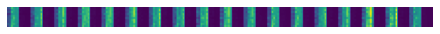

S2s


<Figure size 1440x432 with 0 Axes>

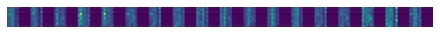

In [21]:
model.show_G_S("./figs/mfeat-fac")

Modified partition coefficient:  {0: 0.5171543353642422, 1: 0.24199002364735067, 2: 0.13969467036220984, 3: 0.16634242417313572, 4: 0.24930421635606748, 5: 0.12696941205327572, 6: 0.3559820364258356, 7: 0.231844767305749, 8: 0.3214944852636449, 9: 0.23471507298612748}
Índice de Rand corrigido: 0.4590836014255971


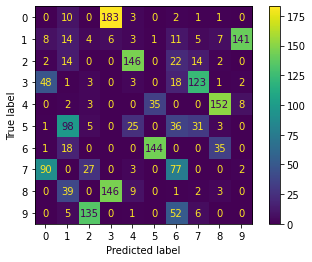

In [22]:
y_predict = pipeline.predict(X) 

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-fou

In [23]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-fou")
X, y = cleaner.transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)

pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-fou/model.json")

repeation: 1 funcão objetivo: 205.58280966429396
Modified partition coefficient: 0.11015652868276526,  adjusted_rand_score: 0.3386579186759299
repeation: 2 funcão objetivo: 198.19023169310444
Modified partition coefficient: 0.12812909835515873,  adjusted_rand_score: 0.38644767441940797
repeation: 3 funcão objetivo: 197.9735288418006
Modified partition coefficient: 0.1286725690885624,  adjusted_rand_score: 0.3874735950412212
repeation: 4 funcão objetivo: 197.97062669264625
Modified partition coefficient: 0.1286800657788154,  adjusted_rand_score: 0.3874735950412212
repeation: 5 funcão objetivo: 197.971014292801
Modified partition coefficient: 0.12867903898706567,  adjusted_rand_score: 0.3874735950412212
repeation: 6 funcão objetivo: 197.97164924340422
Modified partition coefficient: 0.12867738618741043,  adjusted_rand_score: 0.3874735950412212
repeation: 7 funcão objetivo: 197.9723220322176
Modified partition coefficient: 0.12867566805870045,  adjusted_rand_score: 0.3874735950412212
repe

Gs


<Figure size 1440x432 with 0 Axes>

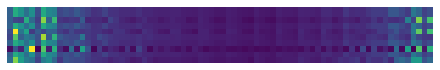

S2s


<Figure size 1440x432 with 0 Axes>

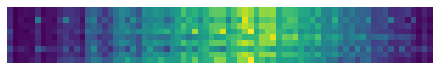

In [24]:
model.show_G_S("./figs/mfeat-fou")

Modified partition coefficient:  {0: 0.6247063576395628, 1: 0.031735062460791164, 2: 0.15056611914305562, 3: 0.026835208377586905, 4: 0.046362524570168095, 5: 0.06323272809021585, 6: 0.03844757363322826, 7: 0.12155316896288815, 8: 0.14189014298427027, 9: 0.03927491124587512}
Índice de Rand corrigido: 0.3883517961828603


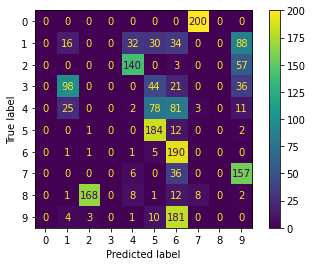

In [25]:
y_predict = pipeline.predict(X)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> mfeat-kar

In [26]:
cleaner = Cleaner()
X, y = cleaner.read_dataset("datasets\mfeat-kar")
X, y = cleaner.transform(X, y)
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 10, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model)])
pipeline.fit(X, y)
model.save_model(f"./model/{m}/mfeat-kar/model.json")


repeation: 1 funcão objetivo: 812.1986598431927
Modified partition coefficient: 0.021838863402657283,  adjusted_rand_score: 0.31596475420690184
repeation: 2 funcão objetivo: 799.0856672501544
Modified partition coefficient: 0.031665420308419456,  adjusted_rand_score: 0.4411685917102599
repeation: 3 funcão objetivo: 807.7506426042157
Modified partition coefficient: 0.025536333415626444,  adjusted_rand_score: 0.3358900651446454
repeation: 4 funcão objetivo: 810.8040391370209
Modified partition coefficient: 0.023176568980652124,  adjusted_rand_score: 0.35720720796079697
repeation: 5 funcão objetivo: 803.0571794615041
Modified partition coefficient: 0.028690270565497444,  adjusted_rand_score: 0.39927478484841494
repeation: 6 funcão objetivo: 810.6909810163633
Modified partition coefficient: 0.02319912011400649,  adjusted_rand_score: 0.35612497416490174
repeation: 7 funcão objetivo: 813.5195425089312
Modified partition coefficient: 0.020917432068806585,  adjusted_rand_score: 0.3019908416613

Gs


<Figure size 1440x432 with 0 Axes>

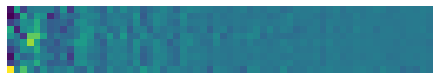

S2s


<Figure size 1440x432 with 0 Axes>

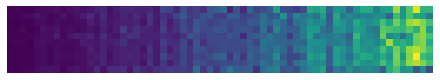

In [27]:
model.show_G_S("./figs/mfeat-kar")

Modified partition coefficient:  {0: 0.06071963355759624, 1: 0.057023736109331646, 2: 0.0024900474584519383, 3: 0.0302673774884491, 4: 0.016069368671210893, 5: 0.007972308038399212, 6: 0.02277040637263772, 7: 0.0950611036861777, 8: 0.010665848470181927, 9: 0.016004763921981136}
Índice de Rand corrigido: 0.43884157714396754


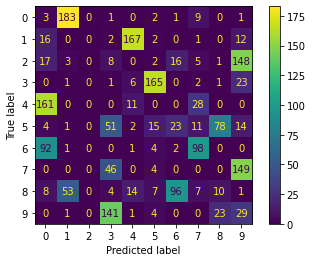

In [28]:
y_predict = pipeline.predict(X)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()

#### datasets -> iris

In [29]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame({len(X.columns.values):iris.target})
X, y = Cleaner().transform(X, y)

model = Trainer(num_class = 3, 
                epochs = 100, 
                threshold = 1e-6, 
                model_creator=FuzzyCMeansGaussianS2, 
                m = m, 
                verbose = False, 
                repeat = 50)
 
pipeline = Pipeline([("Normalizer", Normalizer()), 
                     ("Transformer", Transformer()),                      
                    ("Model", model),
                    ])

pipeline.fit(X, y)
model.save_model(f"./model/{m}/iris/model.json")
y_predict = pipeline.predict(X)


repeation: 1 funcão objetivo: 0.3699561591379164
Modified partition coefficient: 0.8442159049248361,  adjusted_rand_score: 0.9035691663683182
repeation: 2 funcão objetivo: 0.36995615730447495
Modified partition coefficient: 0.8442158104722256,  adjusted_rand_score: 0.9035691663683182
repeation: 3 funcão objetivo: 0.5234724341078217
Modified partition coefficient: 0.8920311744531215,  adjusted_rand_score: 0.443540461316264
repeation: 4 funcão objetivo: 0.5234728190639819
Modified partition coefficient: 0.8920192007906387,  adjusted_rand_score: 0.443540461316264
repeation: 5 funcão objetivo: 0.5234484703973107
Modified partition coefficient: 0.8919155961468139,  adjusted_rand_score: 0.44202390519997947
repeation: 6 funcão objetivo: 0.3699558304203053
Modified partition coefficient: 0.8442117590270616,  adjusted_rand_score: 0.9035691663683182
repeation: 7 funcão objetivo: 0.3699617131724778
Modified partition coefficient: 0.8442360148902243,  adjusted_rand_score: 0.9035691663683182
repeat

In [30]:
new_model = Model()
new_model.load_model("model/iris/model.json")
y_predict = new_model.predict(X, True)#.shape, X.shape


Gs


<Figure size 1440x432 with 0 Axes>

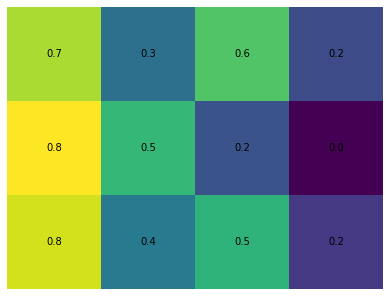

S2s


<Figure size 1440x432 with 0 Axes>

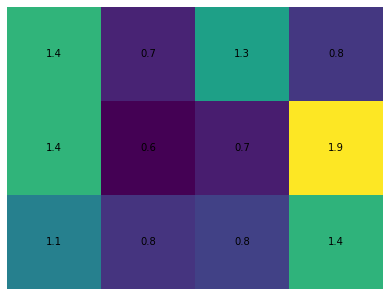

In [31]:
model.show_G_S("figs/iris")

Modified partition coefficient:  {0: 0.987827636245511, 1: 0.7805118186916702, 2: 0.7626428609080327}
Índice de Rand corrigido: 0.9035691663683182


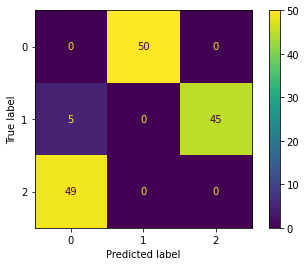

In [32]:
y_predict = pipeline.predict(X) #(2000) <= (2000, 200)

mpcs = {i: Metrics.mpc(model.U[y==i]) for i in range(model.num_class)}

print(f"Modified partition coefficient:  {mpcs}")# f,
print(f"Índice de Rand corrigido: {Metrics.ars(y, model.U.argmax(1))}")# f,

cm = confusion_matrix(y, y_predict)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(model.num_class))
cmd.plot()